# Clickbait Classifier

## Project objectives

This project aims to build a clickbait classifier so that anybody can input its news/blog post/article title and get a clickbait punctuation as output where 1 is clickbait and 0 is no-clickbait.

The project will also attempt to carry out all the natural steps of a machine learning project from retrieving the data needed for the model, to train and evaluate the model. 

## Project architecture
The primary architecture idea (susceptible to changes) comes from the sequence models course where the many-to-one model seems to be the perfect fit to an NLP task where a sentence (in this case a title) is feeded to the model and a classification of the input is computed by the model as the output, classifying the title as a probability of being clickbait.

This model architecture can be tested with multiple variants but probably LSTM or deep LSTMs will perform best.
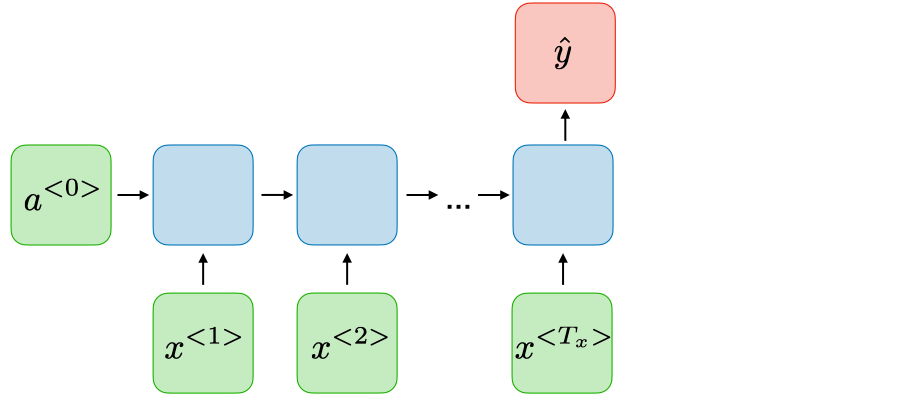

In any case many other architectures can perform this task and may be studied in order to add them or not to this project for different reasons such as first model failure, test other approaches or expanding the project.

## Table Of Contents:
1. [Retrieve data](#toc1)
2. [Preprocess data](#toc2) 
3. [Implement a sequence model architecture](#toc3)
4. [Train the model](#toc4)
5. [Evaluate the model and iterate over hyperparameters and data changes](#toc5)
6. [Play with it and share the project!](#toc6)

## 1. Retrieve data <a class="anchor" id="toc1"></a>
I will use the clcikbait dataset from kaggle authored by @Aman Anand which maps text headlines to 0 or 1, exactly what we want our model to learn.

In [333]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os

from tensorflow.keras.layers import Dense, LSTM, Input, Embedding, Dropout, BatchNormalization
from tensorflow.keras.models import Model

dataset_path = os.path.join(os.getcwd(), 'Dataset\\clickbait_data.csv')
embeddings_path = os.path.join(os.getcwd(), 'Dataset\\glove.6B.50d.txt')

data_df = pd.read_csv(dataset_path)
data_df.head()



,headline,clickbait
0,Should I Get Bings,1
1,Which TV Female Friend Group Do You Belong In,1
2,"The New ""Star Wars: The Force Awakens"" Trailer...",1
3,"This Vine Of New York On ""Celebrity Big Brothe...",1
4,A Couple Did A Stunning Photo Shoot With Their...,1


### 1.1 Vocabulary and word embeddings
Machines do not understand strings as we human do, they understand numbers and operate with them. For this reason the model take as input not a string sentence but an array of numbers, this numbers represent the index of the words in a human vocabulary.

For example the human word 'apple' can be represented as an index in the vocabulary let's say, 3, so the computer will not input 'apple' but 3 to then perform operations in order to offer an output.

For a robust model, cutting-edge technology and methods are going to be implemented and this implies the use of word embeddings.

Embeddings are vectors containing information about different features of a word, and grouping words that have similar semantics. For example the 'apple' word represented by 3, will then be coded as a word embedding and this embedding will be very similar to other words' embedding such as 'banana', 'pear', 'pineapple', etc. 

This is very helpful because our training dataset may not contain a lot of records for a word let's say 'kiwi' but in the other hand it may contain a lot of records with the word 'apple', without word embeddings, the model would not work correctly when an input had the word 'kiwi' in it, but with word embeddings, the model will recognize that the embedding for 'kiwi' (a word that the model has not seen a lot) is very similar to the 'apple' embedding (which it has seen a lot more) and therefore the model will learn that kiwi is a fruit and output a more decent result. 

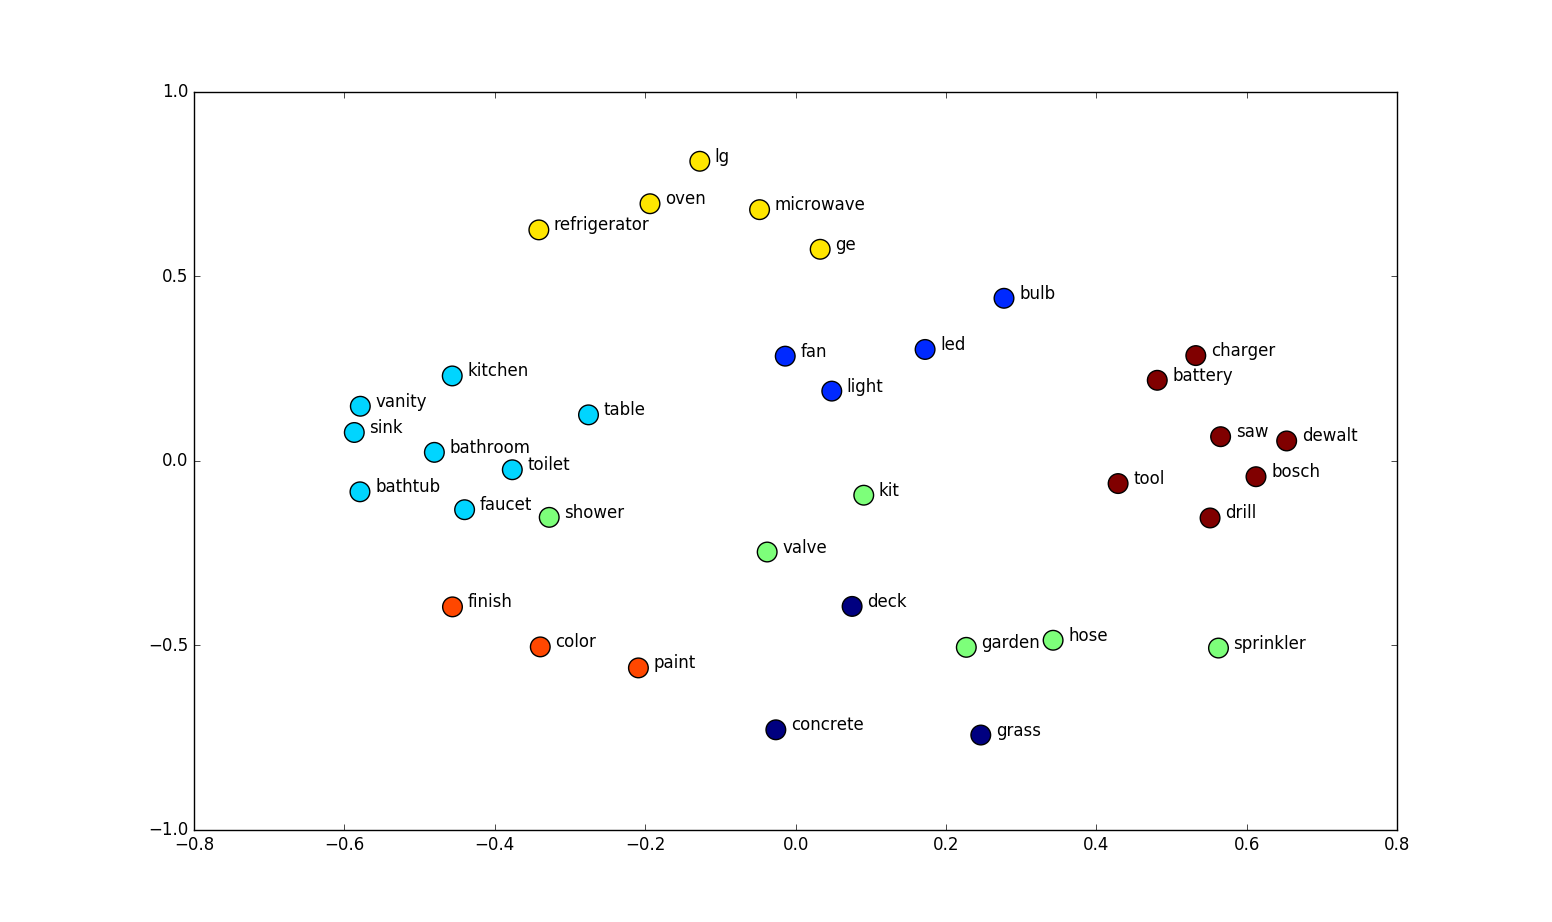

We will add some special tokens that will help the model to understand better when a sentence starts and finishes. ('\[SOS\]', '\[EOS\]')

In [334]:
def build_vocabulary(embeddings_path):
    
    
    word2vec = {}
    idx2word = {}
    word2idx = {}
    with open(embeddings_path, 'r', encoding='utf8') as f:
        for i, line in enumerate(f.readlines()):
            line = line.split()
            word = line[0]
            embedding = line[1:]
            
            word2vec[word] = np.append(np.array(embedding, dtype='float32'), np.zeros(3))
            idx2word[i] = word
            word2idx[word] = i
            
    vocab_size = len(word2idx.keys())
            
            
    return word2vec, idx2word, word2idx

In [335]:
word2vec, idx2word, word2idx = build_vocabulary(embeddings_path)

In [336]:
emb_dim = word2vec['the'].shape[0]
special_tokens = ['<PAD>', '<EOS>', '<SOS>']
num_special_tokens = len(special_tokens)
vocab_len = len(word2idx.keys())

print(emb_dim)
for i in range(num_special_tokens):
    special_oh = tf.one_hot(i, num_special_tokens)
    token_emb = np.append(np.zeros(emb_dim - 3), special_oh)
    token = special_tokens[i]
    
    word2vec[token] = token_emb
    word2idx[token] = vocab_len + i
    idx2word[vocab_len + i] = token
    
vocab_len = len(word2idx.keys())
emb_dim = word2vec[idx2word[0]].shape[0]

53


## 2. Preprocess data <a class="anchor" id="toc2"></a>
### Sentences to indices

Once we have our embeddings, our vocabuary and our dictionaries mapping from index to word and viceversa we can start processing the dataset so we can feed it then to our model.

In [337]:
def sentence2indices(sentence, word2idx):
    indices = []
    indices.append(word2idx['<SOS>'])
    for word in sentence.lower().split():
        if word in word2idx.keys():
            idx = word2idx[word]
            indices.append(idx)
        
    indices.append(word2idx['<EOS>'])
            
    return indices

processed_data_df = data_df.copy()
processed_data_df['headline'] = processed_data_df['headline'].apply(sentence2indices, args=(word2idx,))
print(processed_data_df['headline'][0])
print(data_df['headline'][0])

[400002, 189, 41, 169, 292574, 400001]
Should I Get Bings


### Padding

Once we have mapped our raw sentence inputs to their vocabulary indexes, we have to pad the input because the model only accepts a fixed input length.

This means that if we have a sentence (represented by its indices) with a length of 3 words like: \[3, 56, 7\] and our model only accepts inputs with a length of 4, we have to process the input and expand it to fit a length of 4.

In our vocabulary the 'PAD' token is represented by the index 400000 and there for, the above sentence example will be transformed to: \[3, 56, 7, 40000\].
    
If the input length were fixed to 6, it will be mapped to: \[3, 56, 7, 400000, 40000\]

In [338]:
# We will use as fixed input length the greater sentence length in our dataset.

Tx = processed_data_df['headline'].apply(lambda x: len(x)).max()
print(Tx)

27


In [339]:
def pad_sentence(sentence, Tx, word2idx):
    sentence_len = len(sentence)
    pad_len = Tx - sentence_len
    pad_idx = word2idx['<PAD>']
    
    padded_sentenece = np.concatenate((sentence, np.repeat(pad_idx, pad_len)))
    return padded_sentenece

processed_data_df['headline'] = processed_data_df['headline'].apply(lambda x: np.array(x))
processed_data_df['headline'] = processed_data_df['headline'].apply(pad_sentence, args=(Tx, word2idx,))

### Data processing results
We can now see how our processing functions map a human readable sentence to a fixed length input useful for our model.

In [340]:
print(data_df['headline'][234])
print(processed_data_df['headline'][234])

Here's How To Make A Floral Dog Leash For A Winter Wedding
[400002    197      4    159      7  17873   2926  32422     10      7
   1601   4318 400001 400000 400000 400000 400000 400000 400000 400000
 400000 400000 400000 400000 400000 400000 400000]


### Split the data into train, dev and test set
First we are going to approach the project with a 60/20/20 split on the train, dev and test sets. This means that the training set is going to be 60% of all data and dev and test sets are going to be 50% of the data left.

In [341]:
dataset_size = data_df.shape[0]

train_size = 0.6
dev_size = (1 - 0.6) / 2
test_size = (1 - 0.6) / 2

Now let's shuffle the dataframe to get random data for train, dev and test set

In [342]:
train = processed_data_df.sample(frac=train_size)

dev_test = processed_data_df.drop(train.index)

dev = dev_test.sample(frac=dev_size)

test = dev_test.drop(dev.index)

In [343]:
# We can check that there are not repeated values in the datasets
list(set(train.index) & set(dev.index) & set(test.index))

[]

## 3. Implement a sequence model architecture <a class="anchor" id="toc3"></a>

In this step of the project we have the necessary format data to feed a model and test it. So what comes next is the implementation of the model's architecture defined above.

Since we are using a recurrent architecture, we need to define the model layers in a global scope, so when training, the different words share the same weights

In [344]:
LSTM_unit = LSTM(units=64)
dense_1 = Dense(5, activation='relu')
dense_2 = Dense(1, activation='sigmoid')
dropout1 = Dropout(0.5)

In [346]:
def build_embedding_matrix(vocab_size, emb_dim, word2vec, word2idx):
    
    emb_matrix = np.zeros((vocab_size, emb_dim))
    
    for word, idx in word2idx.items():
        emb_matrix[idx, :] = word2vec[word]
    
    return emb_matrix

emb_matrix = build_embedding_matrix(vocab_len, emb_dim, word2vec, word2idx)
emb_matrix.shape

(400003, 53)

In [351]:
def build_embedding_layer(emb_matrix, vocab_size, emb_dim):
    embedding_layer = Embedding(input_dim=vocab_size, output_dim=emb_dim, trainable=False)
    embedding_layer.build((None,))
    embedding_layer.set_weights([emb_matrix])
    return embedding_layer


In [352]:
def clickbait_classifier(Tx, emb_dim, vocab_size, word2vec, word2idx):
    
    outputs = []
    
    # define input layer
    sentence_indices = Input(shape=(Tx,), dtype='int32')
    
    # define embedding_matrix
    emb_matrix = build_embedding_matrix(vocab_size, emb_dim, word2vec, word2idx)
    
    # define embedding_layer (not trainable)
    embedding_layer = build_embedding_layer(emb_matrix, vocab_size, emb_dim)
    embeddings = embedding_layer(sentence_indices)
    
    # define lstm layer
    lstm_output = LSTM_unit(embeddings)
    
    # define dense 1
    output_dense_1 = dense_1(lstm_output)
    
    # Apply droput
    dense_1_dropout = dropout1(output_dense_1)
    
    # Define Dense 2
    y = dense_2(dense_1_dropout)
    
    # Append outputs
    
    # Build the model
    model = Model(inputs=sentence_indices, outputs=y)
    
    return model

clickbaitML = clickbait_classifier(Tx, emb_dim, vocab_len, word2vec, word2idx)
clickbaitML.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 27)]              0         
                                                                 
 embedding_3 (Embedding)     (None, 27, 53)            21200159  
                                                                 
 lstm_5 (LSTM)               (None, 64)                30208     
                                                                 
 dense_10 (Dense)            (None, 5)                 325       
                                                                 
 dropout_5 (Dropout)         (None, 5)                 0         
                                                                 
 dense_11 (Dense)            (None, 1)                 6         
                                                                 
Total params: 21,230,698
Trainable params: 30,539
Non-train

Once we check the model summary and that all our layers are defined as expected, we can train de model.

## 4. Train the model <a class="anchor" id="toc4"></a>

In [398]:
clickbaitML.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
clickbaitML.fit(np.array(train['headline'].to_list()), np.array(train['clickbait'].to_list()), epochs=150, batch_size=25)



Epoch 1/150
768/768 [==============================] - 7s 7ms/step - loss: 0.6931 - accuracy: 0.5051
Epoch 2/150
768/768 [==============================] - 5s 7ms/step - loss: 0.6932 - accuracy: 0.4943
Epoch 3/150
768/768 [==============================] - 5s 7ms/step - loss: 0.6918 - accuracy: 0.5259
Epoch 4/150
768/768 [==============================] - 5s 7ms/step - loss: 0.6742 - accuracy: 0.6294
Epoch 5/150
768/768 [==============================] - 5s 7ms/step - loss: 0.4578 - accuracy: 0.7975
Epoch 6/150
768/768 [==============================] - 5s 7ms/step - loss: 0.3789 - accuracy: 0.8291
Epoch 7/150
768/768 [==============================] - 5s 7ms/step - loss: 0.3307 - accuracy: 0.8784
Epoch 8/150
768/768 [==============================] - 5s 7ms/step - loss: 0.3136 - accuracy: 0.8796
Epoch 9/150
768/768 [==============================] - 5s 7ms/step - loss: 0.2899 - accuracy: 0.8864
Epoch 10/150
768/768 [==============================] - 6s 7ms/step - loss: 0.2861 - accura

768/768 [==============================] - 6s 8ms/step - loss: 0.1992 - accuracy: 0.9221
Epoch 82/150
768/768 [==============================] - 6s 8ms/step - loss: 0.2018 - accuracy: 0.9205
Epoch 83/150
768/768 [==============================] - 6s 8ms/step - loss: 0.2010 - accuracy: 0.9193
Epoch 84/150
768/768 [==============================] - 6s 8ms/step - loss: 0.2011 - accuracy: 0.9209
Epoch 85/150
768/768 [==============================] - 7s 9ms/step - loss: 0.2001 - accuracy: 0.9195
Epoch 86/150
768/768 [==============================] - 7s 9ms/step - loss: 0.2000 - accuracy: 0.9193
Epoch 87/150
768/768 [==============================] - 7s 9ms/step - loss: 0.2036 - accuracy: 0.9173
Epoch 88/150
768/768 [==============================] - 7s 9ms/step - loss: 0.1946 - accuracy: 0.9240
Epoch 89/150
768/768 [==============================] - 7s 9ms/step - loss: 0.2029 - accuracy: 0.9185
Epoch 90/150
768/768 [==============================] - 7s 9ms/step - loss: 0.2013 - accuracy: 

## 5. Evaluate the model and iterate over hyperparameters and data changes <a class="anchor" id="toc5"></a>

In [443]:
clickbaitML.evaluate(np.array(dev['headline'].to_list()), np.array(dev['clickbait'].to_list()))

80/80 [==============================] - 0s 4ms/step - loss: 0.1282 - accuracy: 0.9703


[0.1281740516424179, 0.9703124761581421]

In [415]:
example_to_test = dev['headline'][dev.index[3]]
example_text = data_df['headline'][dev.index[3]]
print(example_to_test)
print(example_text)

clickbaitML.predict(np.expand_dims(example_to_test, axis=0))

[400002    133    898      6   5266   2046      6   2540     17    375
    952   3181   2947 400001 400000 400000 400000 400000 400000 400000
 400000 400000 400000 400000 400000 400000 400000]
Four arrested in Birmingham UK in connection with July 21 attempted bombings
1/1 [==============================] - 0s 19ms/step


array([[0.00163561]], dtype=float32)

## 6. Play with it and share the project! <a class="anchor" id="toc6"></a>

In [557]:
input_sentence = '5 features that make USB-C unique and how to get the most out of it'
computer_hoy_idx = sentence2indices(input_sentence, word2idx)
computer_hoy_idx

[400002, 422, 1410, 12, 159, 3006, 5, 197, 4, 169, 0, 96, 66, 3, 20, 400001]

In [558]:
computer_hoy_input = pad_sentence(np.array(computer_hoy_idx), Tx, word2idx)
computer_hoy_input

array([400002,    422,   1410,     12,    159,   3006,      5,    197,
            4,    169,      0,     96,     66,      3,     20, 400001,
       400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000,
       400000, 400000, 400000])

In [559]:
prediction = clickbaitML.predict(np.expand_dims(computer_hoy_input, axis=0))

1/1 [==============================] - 0s 20ms/step


In [560]:
print(f"El porcentaje de clickbait de <<{input_sentence}>> es: {int(prediction[0][0] * 100)}%")

El porcentaje de clickbait de <<5 features that make USB-C unique and how to get the most out of it>> es: 99%
